# Análise de Tweets de disastres naturais

tópicos:
- localização dropada por número de NaN e únicos
- pre-processamento: lowercase, lemming, remoção de stopwords e caracters que não são do alfabeto

In [ ]:
%pip install matplotlib
%pip install pandas
%pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("train.csv")
df.head(5)

,id,keyword,location,text,target
0,1118,blew%20up,"Brooklyn, NY",@YahooSchwab easy way to look good after the R...,0
1,1558,bomb,NaN,@dopeitsval ahh you're bomb baby ??,0
2,4830,evacuation,NaN,Run out evacuation hospital indexing remedial ...,1
3,3674,destroy,Trackside California,Wow Crackdown 3 uses multiple servers in multi...,0
4,5368,fire%20truck,NaN,wild night in the village of pugwash every fir...,1


# Pre-Processing

In [3]:
import nltk

nltk.download("stopwords")
sw_nltk = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
class Preprocessor:
    def __init__(self, dataframe: pd.DataFrame):
        self._df = dataframe
    
    def to_lowercase(self, column: str):
        self._df[column] = self._df[column].str.lower()
        return self
        
    def remove_stopwords(self, column: str):
        self._df[column]  = self._df[column].apply(lambda x: [w for w in x.split() if w not in sw_nltk])
        return self
    
    def get_df(self):
        return self._df

In [14]:
preprocessor = Preprocessor(df)

processed_df = preprocessor.to_lowercase("text").remove_stopwords("text").get_df()
processed_df.head(5)

,id,keyword,location,text,target
0,1118,blew%20up,"Brooklyn, NY","[@, h, c, h, w, b, , e, , w, , , l, k, , ...",0
1,1558,bomb,NaN,"[@, p, e, v, l, , h, h, , u, ', r, e, , b, ...",0
2,4830,evacuation,NaN,"[r, u, n, , u, , e, v, c, u, n, , h, p, l, ...",1
3,3674,destroy,Trackside California,"[w, w, , c, r, c, k, w, n, , 3, , u, e, , ...",0
4,5368,fire%20truck,NaN,"[w, l, , n, g, h, , n, , h, e, , v, l, l, ...",1


# EDA

In [123]:
df.describe(include="object")

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


<BarContainer object of 2 artists>

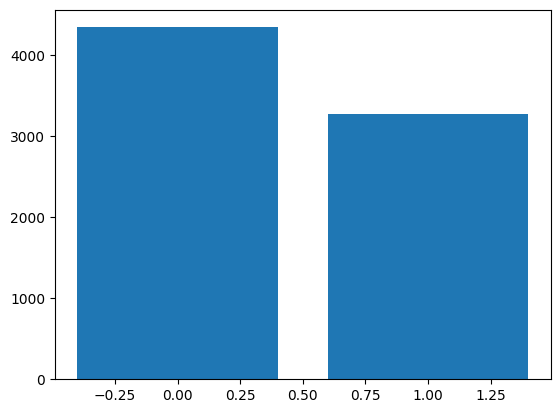

In [28]:
# Verificando desbalanceamento de classes
class_count = df.groupby("target").id.count()
plt.bar(height=class_count, x=class_count.keys())

In [9]:
# verificando entradas NaN nas colunas
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [200]:
from collections import Counter

def count_common_words(series: pd.Series):
    c = Counter()
    
    for row in series:
        row = row.lower()
        tokens = set(row.split())
        for token in tokens:
            if not should_skip(token):
                token = "".join(filter(str.isalpha, token))
                c[token] += 1

    return c

def should_skip(entry: str):
    if entry in STOPWORDS:
        return True

In [201]:
negative = count_common_words(df[df.target == 0].text)
#negative = remove_stopwords_punctuation(negative)
negative.most_common(10)

[('', 1839),
 ('amp', 175),
 ('will', 173),
 ('new', 163),
 ('now', 144),
 ('one', 123),
 ('body', 111),
 ('via', 96),
 ('video', 94),
 ('people', 90)]

In [208]:
positive = count_common_words(df[df.target == 1].text)
positive.most_common(10)
positive["fire"]

163

In [203]:
df[df.text.str.contains("fire")]

,id,keyword,location,text,target
4,5368,fire%20truck,NaN,wild night in the village of pugwash every fir...,1
10,5743,forest%20fires,"Washington, D.C.",As California fires rage Forest Service sounds...,1
19,5325,fire,NaN,Sitting around a fire sounds great right about...,0
89,5778,forest%20fires,"Vancouver, BC",Forest fires could delay @AbbyAirshow but offi...,1
111,5730,forest%20fire,Los Angeles for now,We are having forest fires out here in #socal ...,1
...,...,...,...,...,...
7537,5979,hazard,NaN,@LondonFire Hi ..Is there an email that people...,1
7563,5384,fire%20truck,NaN,@JustineJayyy OHGOD XD I didn't mean it so =P ...,0
7584,8005,razed,NaN,The Latest: More homes razed by Northern Calif...,1
7592,1983,bush%20fires,NaN,@DoriCreates @alhanda seems gov moonbeam betwe...,1


(-0.5, 799.5, 799.5, -0.5)

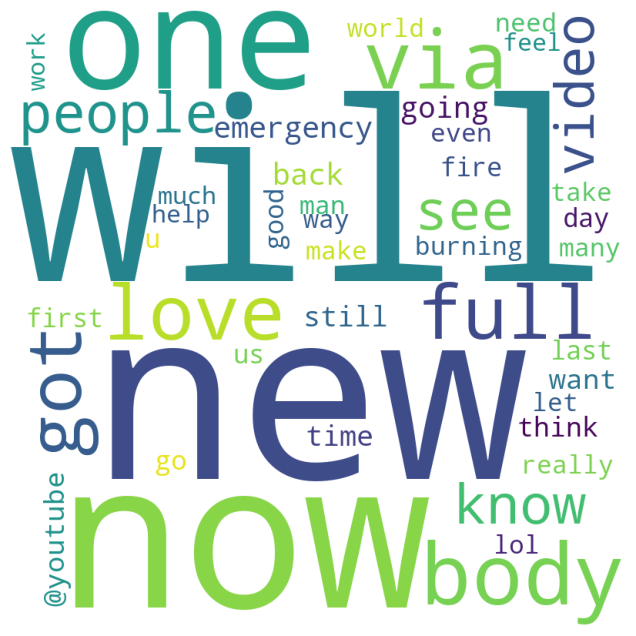

In [121]:
from wordcloud import WordCloud, STOPWORDS

# WordCloud para casos negativos
cloud = WordCloud(width=800, height=800, 
                  background_color="white",
                  max_words=45)
cloud.generate_from_frequencies(negative)

plt.figure(figsize= (8, 8))
plt.imshow(cloud)
plt.axis("off")

(-0.5, 799.5, 799.5, -0.5)

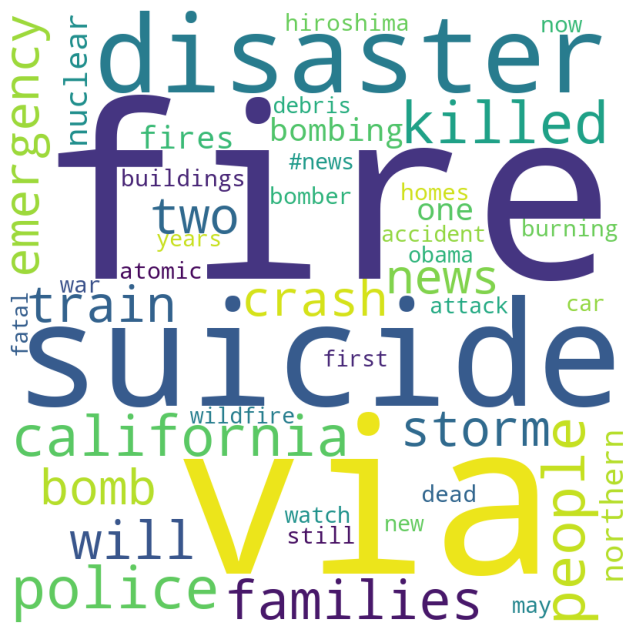

In [120]:
# WordCloud para casos positivos
cloud = WordCloud(width=800, height=800, 
                  background_color="white",
                  max_words=45)
cloud.generate_from_frequencies(positive)

plt.figure(figsize= (8, 8))
plt.imshow(cloud)
plt.axis("off")

(-0.5, 799.5, 799.5, -0.5)

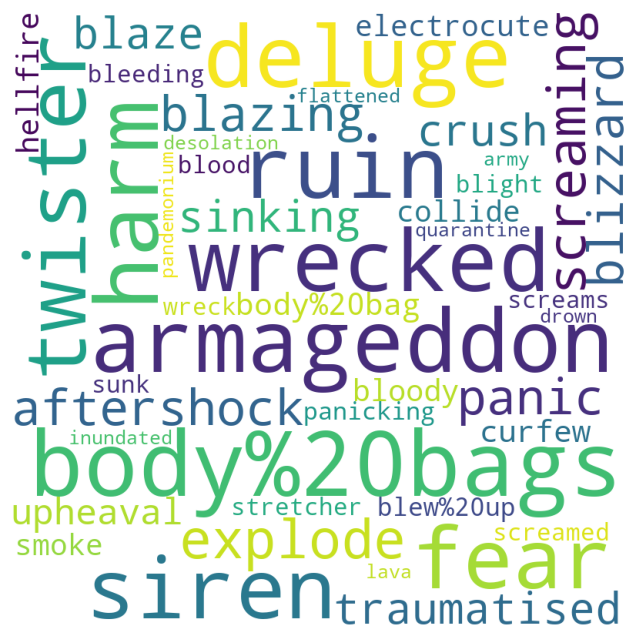

In [148]:
keyword_counts = df[df.target == 1].keyword.value_counts()

# WordCloud para casos positivos
cloud = WordCloud(width=800, height=800, 
                  background_color="white",
                  max_words=45)
cloud.generate_from_frequencies(keyword_counts)

plt.figure(figsize= (8, 8))
plt.imshow(cloud)
plt.axis("off")